In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Number of neurons in each layer
NEURONS = [ 2, 3, 1 ]

# input the dataset
TRAIN_X1 = [ 4, 4, 5, 5, 7,      1,  2,  3,  6,  3,  6,  4,  7 ]
TRAIN_X2 = [ 2, 4, 3, 1, 2,      2,  1,  1,  5,  6,  7,  6,  6 ]
TRAIN_Z  = [ 1, 1, 1, 1, 1,     -1, -1, -1, -1, -1, -1, -1, -1 ]
TRAIN_N  = len(TRAIN_X1)
TRAIN_X0 = np.ones(TRAIN_N)

TEST_X1 = [ 4, 5, 3, 5, 6, 7,    3,  8,  4,  7,  2,  2 ]
TEST_X2 = [ 1, 2, 4, 4, 1, 1,    2,  7,  7,  5,  3,  5 ]
TEST_Z  = [ 1, 1, 1, 1, 1, 1,   -1, -1, -1, -1, -1, -1 ]
TEST_N  = len(TEST_X1)
TEST_X0 = np.ones(TEST_N)

TRAIN_X  = np.array( [TRAIN_X0, TRAIN_X1, TRAIN_X2] ).T

## A)

In [3]:
def plot_set(h,X1,X2, ax=plt, title='Set'):
    ax.scatter(x=X1[:h], y=X2[:h], color='b' )
    ax.scatter(x=X1[h:], y=X2[h:], color='r' )
    ax.set_title( title )

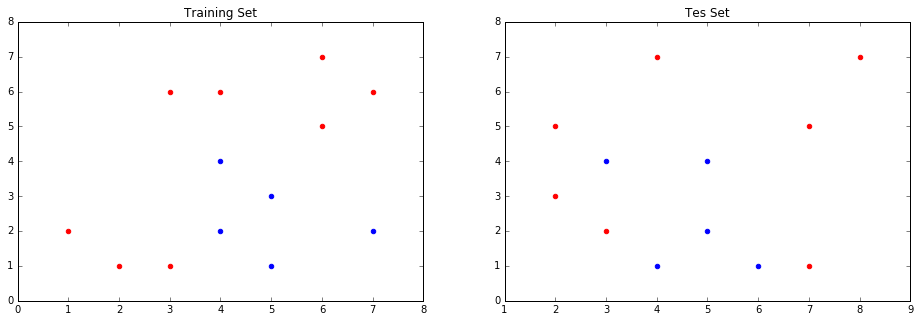

In [4]:
fig, (ax1, ax2) = plt.subplots( 1,2, figsize=(16,5) )

plot_set(5, TRAIN_X1, TRAIN_X2, ax1, 'Training Set')
plot_set(5, TEST_X1 , TEST_X2 , ax2, 'Tes Set'     )

<br/><br/><br/><br/>

Taking inspiration from the book [Neural Networks](https://page.mi.fu-berlin.de/rojas/neural/chapter/K7.pdf) by R. Rojas.

![Network](Network.png "Network")

### First step: feed-forward computation
The vector $o$ is presented to the network. The vectors $o^{(1)}$ and $o^{(2)}$ are computed and stored. The evaluated derivatives of the activation functions are also stored at each unit.

### Second step: backpropagation to the output layer
We are looking for the first set of partial derivatives $ \partial E/\partial w_{i,j}^{(2)} = \delta_j^{(2)} o_i^{(1)} $, where

$$ \delta_j^{(2)} = o_j^{(2)}(1 − o_j^{(2)})(o_j^{(2)} − t_j ) $$

### Third step: backpropagation to the hidden layer
￼Now we want to compute the partial derivatives $\partial E/ \partial w^{(1)}$. Each unit $j$ in the hidden layer is connected to each unit $q$ in the output layer with an edge of weight $w^{(2)}$, for $q = 1,\dots m$. The backpropagated error up to unit $j$ in
the hidden layer must be computed taking into account all possible backward paths.
The backpropagated error is then
$$ \delta_j^{(1)} = o_j^{(1)}(1 − o_j^{(1)}) \sum_{q=1}^m w_{j,q}^{(2)} \delta_q^{(2)} $$

### Fourth step: weight updates
After computing all partial derivatives the network weights are updated in the negative gradient direction. 
A learning constant $\eta$ defines the step length of the correction. 
The corrections for the weights are given by

$$ \Delta w_{i,j}^{(2)} = − \eta \, o_i^{(1)} \, \delta_j^{(2)}, \qquad i=1,\dots,k+1 \quad , \quad j=1,\dots,m $$

and

$$ \Delta w_{i,j}^{(1)} = − \eta \, o_{i} \, \delta_j^{(1)}, \qquad i=1,\dots,n+1 \quad , \quad j=1,\dots,k $$

# Implementation

In [5]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def step(x):
    return np.where( x > 0, 1, -1 )

Wall time: 2.58 s


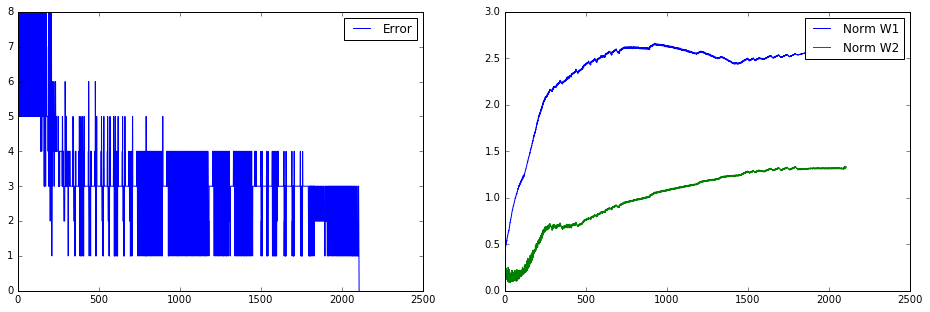

In [8]:
%%time

# Random initial weights ( Including Bias )
W1_initial  = np.random.uniform( -.1, .1, size=( NEURONS[0]+1, NEURONS[1] ) )
W2_initial  = np.random.uniform( -.1, .1, size=( NEURONS[1]+1, NEURONS[2] ) )

eta    = 0.1
errors = []
norm_1 = []
norm_2 = []

W1 = W1_initial
W2 = W2_initial

n = NEURONS[0]
k = NEURONS[1]
m = NEURONS[2]

del_1   = np.empty( k )
del_2   = np.empty( m )

del_w_1 = np.empty( [ n+1, k ] )
del_w_2 = np.empty( [ k+1, m ] )

for epoch in range( 25000 ):
    
    del_w_1_avg = np.zeros( [ n+1, k ] )
    del_w_2_avg = np.zeros( [ k+1, m ] )

    total_error = 0

    for s in range( TRAIN_N ):

        # First step: feed-forward computation
        O_   = TRAIN_X[s]
        O    = TRAIN_X[s][1:]
        
        net1 = np.dot( O_, W1 )
        
        O1   = sigmoid(net1)
        O1_  = [ 1, *O1 ]

        O2   = np.dot( O1_, W2 )

        # Second step: backpropagation to the output layer
        for j in range( 0, m ) :  # For us, j=0 only
            del_2[j] = ( step(O2[j]) - TRAIN_Z[s] ) # * O2[j] * (1 - O2[j])

        # Third step: backpropagation to the hidden layer
        for j in range( 0, k ) :  # This should be vectorialized
            del_1[j] = O1[j] * (1 - O1[j]) * W2[j,:] * del_2

        # Fourth step: weight updates
        for i in range(k+1):
            for j in range(m):
                del_w_2[i,j] = - eta * O1_[i] * del_2[j]

        for i in range(n+1):
            for j in range(k):
                del_w_1[i,j] = - eta * O_[i] * del_1[j]

        del_w_1_avg += del_w_1 / TRAIN_N
        del_w_2_avg += del_w_2 / TRAIN_N

        total_error += np.abs( ( step(O2) - TRAIN_Z[s] ) ) * 0.5
        
    W1 += del_w_1_avg
    W2 += del_w_2_avg

    errors.append( total_error )
    norm_1.append( np.abs( W1 ).sum() )
    norm_2.append( np.abs( W2 ).sum() )
    
    if total_error == 0 : break


# Plot what happened
fig, (ax1, ax2) = plt.subplots( 1,2, figsize=(16,5) )
    
ax1.plot(range(0,len(errors)), errors, label='Error'   )
ax1.legend()

ax2.plot(range(0,len(norm_1)), norm_1, label='Norm W1' ) 
ax2.plot(range(0,len(norm_2)), norm_2, label='Norm W2' ) 
_ = ax2.legend()

In [9]:
for s in range( 0, TRAIN_N ):
    # Feed-forward computation
    O_   = TRAIN_X[s]
    net1 = np.dot( O_, W1 )
    O1   = sigmoid(net1)
    O1_  = [ 1, *O1 ]
    O2   = np.dot( O1_, W2 )
    print( step(O2) )

[1]
[1]
[1]
[1]
[1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]


<br/><br/><br/><br/>